In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures,FunctionTransformer,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from DataProcessing import *
from FeatureEngineering import *


In [32]:
class Estimator:
    def __init__(self,train_df=None,Xtest_df=None,response_name=None,folds=None,
                 modelList=None,lossDict=None,lossStdDict=None):
        '''
        init method for salary linear estimation
        '''
        self.train_df = train_df
        self.Xtest_df = Xtest_df
        # split X features and reponse from train df
        self.Xtrain_df = self.train_df.drop(response_name,axis=1)
        self.folds = folds
        self.ytrain_df = self.train_df[response_name]
        self.modelList = modelList
        self.lossDict = lossDict
        self.lossStdDict = lossStdDict

    def _baseline_estimator(self,figsz=(10,6)):
        '''
        define naive baseline estimator as mean salary
        '''
        mean_ytrain = np.mean(self.ytrain_df)
        # assign constant ndarray 
        self.yhat_train_baseline = np.full(shape=(len(self.ytrain_df),1),fill_value=mean_ytrain)
        devs_train_baseline = self.ytrain_df - self.yhat_train_baseline
        self.mse_train_baseline = np.mean(np.square(devs_train_baseline))
        self.rmse_train_baseline = np.sqrt(self.mse_train_baseline)
        print('mse_sk:',mean_squared_error(self.ytrain_df,self.yhat_train_baseline))
        print('rmse_sk:',np.sqrt(mean_squared_error(self.ytrain_df,self.yhat_train_baseline)))

    def plot_loss(self,hyper_arr=None,train_loss_arr=None,val_loss_arr=None,figsz=(10,6),xlabel=None,ylabel=None,folds=None):
        '''
        visualize loss in loss_arr at each hyperparameter in hyper_arr
        '''
        f,ax = plt.subplots(figsize=figsz)
        ax.plot(hyper_arr,train_loss_arr,color='blue',label='train')
        ax.plot(hyper_arr,val_loss_arr,color='red',label='validation')
        ax.set(title='{}-Fold Cross-Validation Loss'.format(folds),xlabel=xlabel,ylabel=ylabel)
        ax.legend()#(loc='upper_left')
        
    def _tune_hyperparams(self,model=None,params=None,lossfunc='neg_mean_squared_error',figsz=(10,6),ylabel='MSE',plot_param='randomforestregressor__n_estimators'):
        '''
        method to tune model hyperparameters with GridSearchCV
        '''
        gs = GridSearchCV(model,param_grid=params,cv=self.folds,
                         scoring=lossfunc,return_train_score=True)
        gs.fit(self.Xtrain_df,self.ytrain_df)
        best_model = gs.best_estimator_
        best_score = gs.best_score_
        best_test_score_array = gs.cv_results_['mean_test_score']
        if lossfunc=='neg_mean_squared_error':
            best_score = -1.0*best_score
            best_test_score_array = -1.0*best_test_score_array
            scores_train = -1.0*gs.cv_results_['mean_train_score']
            scores_val = -1.0*gs.cv_results_['mean_test_score']
        else:
            best_score = best_score
            best_test_score_array = best_test_score_array
            scores_train = gs.cv_results_['mean_train_score']
            scores_val = gs.cv_results_['mean_test_score']
        print('scores_train:',scores_train)
        print('scores_val:',scores_val)
        print('tuned optimal hyperparmeter:',gs.best_params_)   
        print('gridsearch best score:',best_score)
        # viz loss vs. hyperparameters
        xs = params[plot_param]
        self.plot_loss(hyper_arr=xs,train_loss_arr=scores_train,val_loss_arr=scores_val,
                           figsz=figsz,xlabel=plot_param,ylabel=ylabel,folds=self.folds)
        # return hyperparameter search best model:    
        return best_model 
        
    def _train_estimator(self,estimator=None):
        '''
        train and cross validate linear estimator and return train mse,rmse
        '''
        # compute k-fold cross-validated neg_mse
        scores_array = cross_val_score(estimator,
                                      self.Xtrain_df,self.ytrain_df,
                                      scoring='neg_mean_squared_error',
                                      cv=self.folds)
        print(scores_array)
        #mse 
        cv_mse_mean = np.nanmean(-1.0*scores_array)
        cv_mse_std = np.std(scores_array)
        # rmse
        scores_array_rmse = np.sqrt(-1.0*scores_array)
        cv_rmse_mean = np.nanmean(-1.0*scores_array_rmse)
        cv_rmse_std = np.std(scores_array_rmse)
        return cv_mse_mean,cv_mse_std,cv_rmse_mean,cv_rmse_std
    
    def _train_summary(self,estimator,cv_mse_mean=None,cv_mse_std=None,cv_rmse_mean=None,cv_rmse_std=None):
        '''
        summarize estimator training results
        '''
        print('\n{}'.format(estimator))
        print('\ntrain {}-fold mean MSE={:,.2f}'.format(self.folds,cv_mse_mean))
        print('\ntrain {}-fold std MSE={:,.2f}'.format(self.folds,cv_mse_std))
        print('\ntrain {}-fold mean RMSE={:,.2f}'.format(self.folds,cv_rmse_mean))
        print('\ntrain {}-fold std RMSE={:,.2f}'.format(self.folds,cv_rmse_std))
    
    def _train_estimators(self):
        '''
        train estimators and report cross-validated mean loss
        '''
        for lm in self.modelList:
            cv_mse_mean,cv_mse_std,cv_rmse_mean,cv_rmse_std = self._train_estimator(lm)
            self.lossDict[lm] = cv_mse_mean
            self.lossStdDict[lm] = cv_mse_std 
            self._train_summary(lm,
                                cv_mse_mean=cv_mse_mean,cv_mse_std=cv_mse_std,
                                cv_rmse_mean=cv_rmse_mean,cv_rmse_std=cv_rmse_std)

#### Instantiate data object $data$

In [33]:
ordinalcodes = {'degree':{'NONE':0,'HIGH_SCHOOL':1,'BACHELORS':2,'MASTERS':3,
                          'DOCTORAL':4},
                'jobType':{'JANITOR':0,'JUNIOR':1,'SENIOR':2,'MANAGER':3,
                           'VICE_PRESIDENT':4,'CFO':5,'CTO':6,'CEO':7},
#                 'industry':{'EDUCATION':0,'SERVICE':1,'AUTO':2,'HEALTH':3,'WEB':4,'FINANCE':5,'OIL':6}
                'major':{'NONE':0,'LITERATURE':1,'BIOLOGY':2,'CHEMISTRY':3,
                         'PHYSICS':4,'COMPSCI':5,'MATH':6,'BUSINESS':7,'ENGINEERING':8},
               }


# from DataProcessing import * 
data = Data(fname_Xtrain='train_features.csv',fname_ytrain='train_salaries.csv',
         fname_Xtest='test_features.csv',
         columns_cat=['companyId','degree','industry','jobType','major'],
         columns_num=['milesFromMetropolis','yearsExperience'],
         ylabel='salary',joinId='jobId',ordinal_dict=ordinalcodes)

train_df = data._encode_categorical_features(data.train_df,ordinal_dict=None,nominal_cols=['companyId','industry','jobType'])    


#### Instantiate feature engineering object and compute grouped statistics as new features   

In [34]:
featureEng = FeatureEng(data_object=data) 
train_df = featureEng._compute_new_features(train_df,cat_columns=featureEng.data.columns_cat,
                                            num_columns=featureEng.data.columns_num,clean=True)
train_df.head()

,milesFromMetropolis,yearsExperience,jobId,salary,companyId,degree,industry,jobType,major,cat_group_min,...,milesFromMetropolis_quantile_salary_median,milesFromMetropolis_quantile_salary_mean,milesFromMetropolis_quantile_salary_max,milesFromMetropolis_quantile_salary_std,yearsExperience_quantile,yearsExperience_quantile_salary_min,yearsExperience_quantile_salary_median,yearsExperience_quantile_salary_mean,yearsExperience_quantile_salary_max,yearsExperience_quantile_salary_std
0,83,10,JOB1362684407687,130,31,3,3,1,6,98,...,97.0,100.813725,215,32.664245,1,34,97.0,100.813725,215,32.664245
1,73,3,JOB1362684407688,101,11,2,6,0,7,90,...,92.0,90.646192,203,33.695502,0,24,92.0,90.646192,203,33.695502
2,38,10,JOB1362684407689,137,48,1,3,7,8,116,...,114.0,115.997442,212,33.006953,1,48,114.0,115.997442,212,33.006953
3,17,8,JOB1362684407690,142,32,1,0,5,2,77,...,121.0,121.643735,211,33.136505,1,45,121.0,121.643735,211,33.136505
4,16,8,JOB1362684407691,163,60,0,2,7,8,94,...,118.0,119.155612,229,34.557913,1,44,118.0,119.155612,229,34.557913


#### Instantiate estimator object $m$

In [8]:
m = Estimator(train_df=shuffle(train_df[:50000]).drop(data.id,axis=1),Xtest_df=data.Xtest_df,response_name=data.ylabel,
              folds=5,modelList=[],lossDict={},lossStdDict={})

#### Tune RandomForest *n_estimators* hyperparameter
- *n_estimators* is the number of trees in the forest
- the estimator becomes more flexible as *n_estimators* increases

scores_train: [ 47.88924102  45.95191403]
scores_val: [ 331.28063262  327.60213604]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 100, 'randomforestregressor__verbose': False}
gridsearch best score: 327.602136041


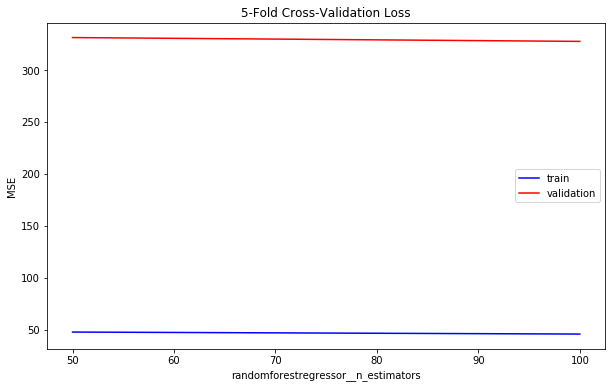

In [9]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__verbose':[False],   
                                                         'randomforestregressor__n_estimators':[50,100], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__n_estimators')   


#### Tune RandomForest *max_depth* hyperparameter:
- *max_depth* hyperparameter is the maximum depth of the tree; if *None*, then nodes are expanded until all leaves are pure or until all leaves contain less than *min_samples_split* samples 
- optimal search returned  minimum validation loss at max depth value around 10

scores_train: [ 479.86778368  401.20379108  349.85258864  324.87394666  307.65985597
  290.81500167  270.00910472  243.73587988  214.60941947  183.14861286
  154.50535098  128.5767367   106.92889978   90.2863269    78.10055659
   68.72510511   62.51118011]
scores_val: [ 484.6924634   407.61712085  358.9577785   337.17012615  325.62935664
  320.84046703  320.11081743  320.58941454  321.67617229  323.20873925
  325.34050631  327.65632055  329.05557578  330.46219804  332.75588493
  334.2197458   333.96557174]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__verbose': False, 'randomforestregressor__max_depth': 9}
gridsearch best score: 320.110817432


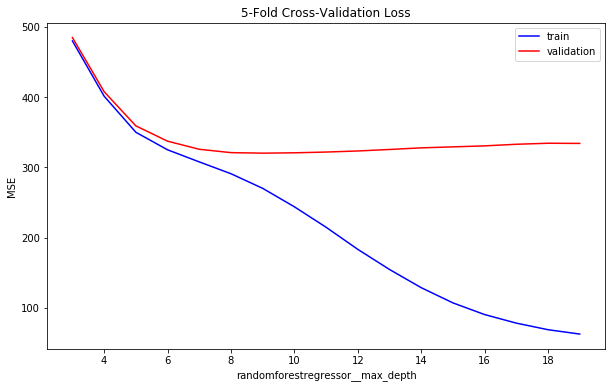

In [10]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':np.arange(3,20,1),  
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__max_depth') 

#### Tune RandomForest min_samples_split hyperparameter:
- *min_samples_split* hyperparameter is the minimum number of samples required to split an internal node.
- smaller values of *min_samples_split* results in a more flexible estimator 
- optimal search returned minimum validation loss at *min_samples_split* value around 60

scores_train: [ 244.74639091  249.71593479  254.73718867  259.0813831   262.80450438
  266.17056292  269.42703348  272.59586126]
scores_val: [ 320.40043994  320.00174358  320.24773488  319.50018925  319.54218843
  319.59998546  319.30178728  319.78795654]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__min_samples_split': 65, 'randomforestregressor__verbose': False, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 10}
gridsearch best score: 319.30178728


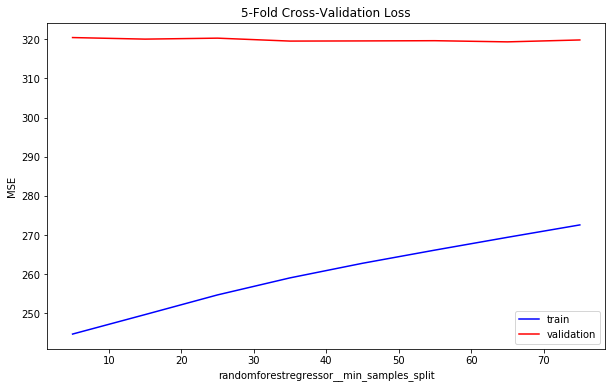

In [12]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':[10],  
                                                         'randomforestregressor__min_samples_split':np.arange(5,76,10), 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__min_samples_split') 

#### Tune RandomForest *min_samples_leaf* hyperparameter
- *min_samples_leaf* hyperparameter is the minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least *min_samples_leaf* training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
- Smaller values of *min_samples_leaf* results in a more flexible estimator.
- GridSearch returned minimum validation loss at around *min_samples_leaf* value of 1.

scores_train: [ 268.50981218  288.61191351  305.24530424]
scores_val: [ 319.73043114  320.19146712  324.42997353]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__min_samples_split': 62, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__verbose': False, 'randomforestregressor__max_depth': 10}
gridsearch best score: 319.730431137


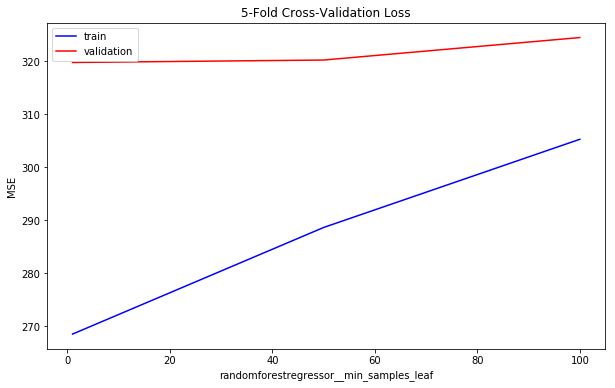

In [13]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':[10],  
                                                         'randomforestregressor__min_samples_split':[62], 
                                                         'randomforestregressor__min_samples_leaf':[1,50,100], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__min_samples_leaf') 

#### Tune RandomForest *min_weight_fraction_leaf* hyperparameter
- *min_weight_fraction_Leaf* hyperparameter is the minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
- A lower *min_weight_fraction_leaf* value results in a more flexible model.
- GridSearch returned a minimum validation loss at the default value of *min_weight_fraction_leaf*=0.


scores_train: [ 268.73656781  328.2143697   483.98249772]
scores_val: [ 319.59677107  338.9710709   488.52513329]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__min_samples_split': 62, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_depth': 10, 'randomforestregressor__min_weight_fraction_leaf': 0, 'randomforestregressor__verbose': False}
gridsearch best score: 319.596771073


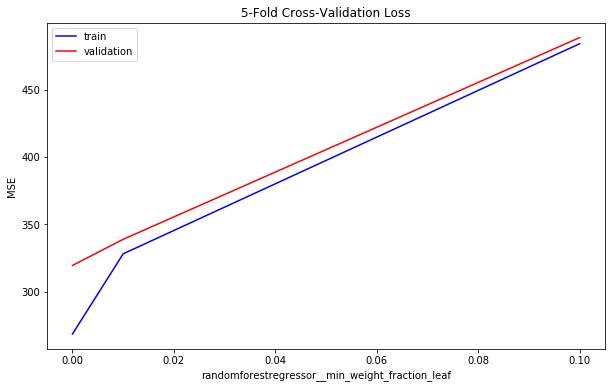

In [20]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':[10],  
                                                         'randomforestregressor__min_samples_split':[62], 
                                                         'randomforestregressor__min_samples_leaf':[1], 
                                                         'randomforestregressor__min_weight_fraction_leaf':[0,1e-2,0.1], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__min_weight_fraction_leaf') 

#### Tune RandomForest *max_features* hyperparameter:
- max_features hyperparameter is the number of
- GridSearch returned minimum validation loss at around *max_features* value 0.625

scores_train: [ 363.2116952   306.66199273  289.81146854  284.32940706  278.49628149
  274.39765181  272.23999553  270.72640301  270.81677007  269.77194195]
scores_val: [ 395.98343903  343.04798932  327.08669171  323.24533237  319.64442649
  319.20483503  319.07574021  318.92848057  318.94775012  319.26831206]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__min_samples_split': 62, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 0.625, 'randomforestregressor__max_depth': 10, 'randomforestregressor__min_weight_fraction_leaf': 0, 'randomforestregressor__verbose': False}
gridsearch best score: 318.92848057


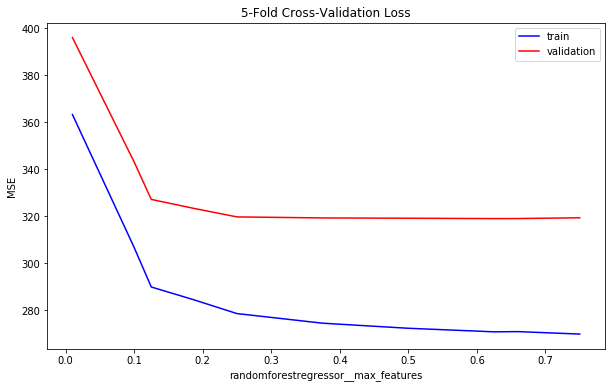

In [24]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':[10],  
                                                         'randomforestregressor__min_samples_split':[62], 
                                                         'randomforestregressor__min_samples_leaf':[1], 
                                                         'randomforestregressor__min_weight_fraction_leaf':[0], 
                                                         'randomforestregressor__max_features':[.01,.1,.125,.1875,.25,.375,.5,.625,.66,.75], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__max_features') 

#### Tune RandomForest hyperparameter *max_leaf_nodes*
- *max_leaf_nodes* hyperparameter will grow trees with *max_leaf_nodes* in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
- GridSearch returned minimum loss at *max_leaf_nodes*=*None*

scores_train: [ 435.92163602  308.80325649  308.32474505  261.08847389  270.72392497]
scores_val: [ 440.80917934  325.77119496  325.37726734  318.84850439  318.61946605]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__min_samples_split': 62, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 0.625, 'randomforestregressor__max_leaf_nodes': None, 'randomforestregressor__min_weight_fraction_leaf': 0, 'randomforestregressor__max_depth': 10, 'randomforestregressor__verbose': False}
gridsearch best score: 318.619466048


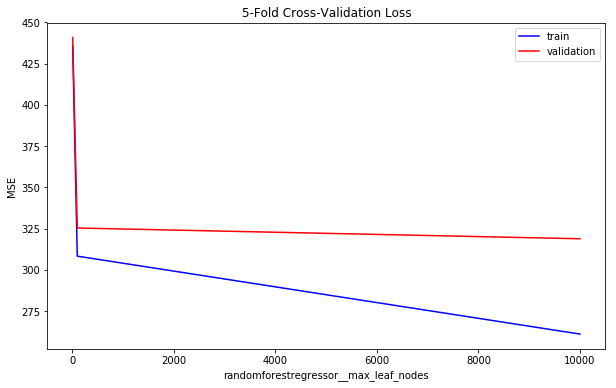

In [27]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':[10],  
                                                         'randomforestregressor__min_samples_split':[62], 
                                                         'randomforestregressor__min_samples_leaf':[1], 
                                                         'randomforestregressor__min_weight_fraction_leaf':[0], 
                                                         'randomforestregressor__max_features':[.625], 
                                                         'randomforestregressor__max_leaf_nodes':[10,100,100,10000,None], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__max_leaf_nodes') 

#### Tune RandomForest *min_impurity_decrease* hyperparameter
- *min_impurity_decrease* specifies when a node will be split if this split induces a decrease of the impurity greater than or equal to this value.
- a smaller value of *min_impurity_decrease* specifies a more flexible estimator.
- GridSearch returned minimal validation loss with *min_impurity_decrease*=0.

scores_train: [ 270.81000135  279.14954203  314.08847485]
scores_val: [ 319.02322976  319.43397737  328.56649831]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__min_samples_split': 62, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 0.625, 'randomforestregressor__max_leaf_nodes': None, 'randomforestregressor__min_weight_fraction_leaf': 0, 'randomforestregressor__min_impurity_decrease': 0, 'randomforestregressor__max_depth': 10, 'randomforestregressor__verbose': False}
gridsearch best score: 319.023229757


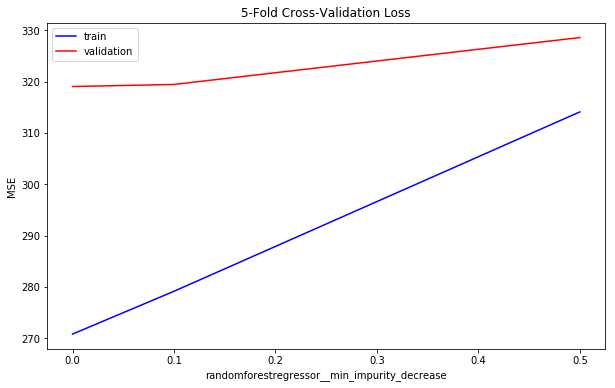

In [28]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':[10],  
                                                         'randomforestregressor__min_samples_split':[62], 
                                                         'randomforestregressor__min_samples_leaf':[1], 
                                                         'randomforestregressor__min_weight_fraction_leaf':[0], 
                                                         'randomforestregressor__max_features':[.625], 
                                                         'randomforestregressor__max_leaf_nodes':[None], 
                                                         'randomforestregressor__min_impurity_decrease':[0,.1,.5], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__min_impurity_decrease') 

#### Tune RandomForest hyperparameter *bootstrap*
- *bootstrap* hyperparameter specifies whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree.
- bootstrapped samples are preferred when building trees in the random forest

scores_train: [ 270.92885501  258.17345319]
scores_val: [ 318.60964941  322.08097166]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 30, 'randomforestregressor__min_samples_split': 62, 'randomforestregressor__bootstrap': True, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 0.625, 'randomforestregressor__max_leaf_nodes': None, 'randomforestregressor__min_weight_fraction_leaf': 0, 'randomforestregressor__min_impurity_decrease': 0, 'randomforestregressor__max_depth': 10, 'randomforestregressor__verbose': False}
gridsearch best score: 318.609649411


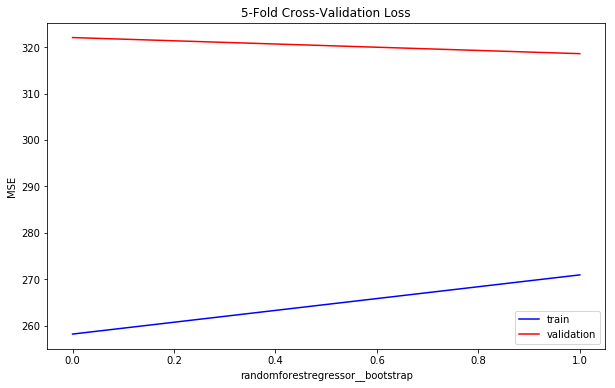

In [29]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[30], 
                                                         'randomforestregressor__max_depth':[10],  
                                                         'randomforestregressor__min_samples_split':[62], 
                                                         'randomforestregressor__min_samples_leaf':[1], 
                                                         'randomforestregressor__min_weight_fraction_leaf':[0], 
                                                         'randomforestregressor__max_features':[.625], 
                                                         'randomforestregressor__max_leaf_nodes':[None], 
                                                         'randomforestregressor__min_impurity_decrease':[0], 
                                                         'randomforestregressor__bootstrap':[True,False], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__bootstrap') 